In [1]:
import numpy as np
from numpy.linalg import matrix_rank

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import scipy.stats as sps
import cvxpy as cvx

from PIL import Image

### Задача

Восстановить исходные картинки, если даны их 'линейные комбинации'. При этом коэффициенты, с которыми были взяты оригинальные картинки, неизвестны. То есть, имеем $$X = AS,$$ где S - матрица исходных векторизованных картинок, М - матрица коэффициентов (матрица смешения), а S - матрица векторизованных наблюдаемых картинок. Известна только матрица S.

### Решение

Воспользуемся методом CAMNS, подробно описанным в [статье](https://www.researchgate.net/profile/Chong-Yung-Chi/publication/251134144_A_Convex_Analysis_Framework_for_Blind_Separation_of_NonNegative_Sources/links/5a1e7622aca272cbfbc04995/A-Convex-Analysis-Framework-for-Blind-Separation-of-NonNegative-Sources.pdf?_sg%5B0%5D=OMb8GSQ1miraTnwj9MuTl_sWqMTmx1MXLO3B6zfVi4OFqD1thTV7qA1ojzXKQSucagGKOYVy8QmNQOoE5oLX7Q.HcFDAcJ9Gd4ltbvqp_7ndt1Yhg35PL0PJa3iOnYJcpBA3OIiuYwL72YJ6ry46Cb_NEHNsAZBgi3jpf8EMTzYEg.b9vSGHXLraOewNOZkrAVlPI3Gdpmzc9JO-KbP2hbAA1PmpKU1T0TtgFylKVSCgVhmm7gCmd1kar37FwL4MKtKQ&_sg%5B1%5D=WIdyA5iABGfzLmDfwEfigkwWoN-Ahwrw8Z3t4D_7wZLt5iAIKaiCWZQYsLGAFMr59D7yASkWgn4KQy0-4-DErwnDWhtnvybd10KIsKCKc3BT.HcFDAcJ9Gd4ltbvqp_7ndt1Yhg35PL0PJa3iOnYJcpBA3OIiuYwL72YJ6ry46Cb_NEHNsAZBgi3jpf8EMTzYEg.b9vSGHXLraOewNOZkrAVlPI3Gdpmzc9JO-KbP2hbAA1PmpKU1T0TtgFylKVSCgVhmm7gCmd1kar37FwL4MKtKQ&_iepl=).
Отметим, что для применения метода небходимо, чтобы все элементы матрицы S были неотрицательны, сумма коэффиентов для каждого смешения равнялась единице, а матрица А имела полный столбцовый ранг, причем строк должно быть больше, чем столбцов.

In [2]:
def is_ext_pt(C, d, alpha, tol):  
    """
    Verify if alpha is an extreme point of the polyhedral set
         { a | Ca+ d => 0 }
    It essentially implements Lemma 6.
    
    ---Inputs----
     (C,d) is the set of polyhedron parameters
     alpha is the point to be tested
     tol specifies the numerical tolerance (say, 1e-3)
     
    ---Output----
     flag= 1 if alpha is an extreme point; and flag= 0 otherwise.
 
    """
    L, D = C.shape
    T = C[np.all(np.abs((C @ alpha + d)[:, np.newaxis]) < tol, axis=1), :]
    flag = (matrix_rank(T, tol=tol) == D)
    return flag

In [42]:
def CAMNS(X, N):
    """"
     Inputs:
     
     X is the L-by-M observation matrix, where M is the number of
       observations.
     N is the number of sources.
    Output: 
    
     hS is the L-by-N extracted soruce matrix, where L is the data length.
    """
    TOL_LP = 1e-3     # tolerance for (small) numerical errors in LP
    TOL_EXT = 1e-6    # tolerance for extreme-point validation
    TOL_ZEROS = 1e-6  # tolerance for eliminating zero observation points
    
    L, M = X.shape
  
    d = np.mean(X, axis=1)
    
    C, V, S = np.linalg.svd(X - d[:, np.newaxis], full_matrices=False)
    C = C[:, :N-1]

    el = 0

    hS = np.zeros((0, L))
    B = np.diag(np.ones(L))

    while el < N:
        w = sps.norm.rvs(size=L)
        r = B.dot(w)  
        
        alpha1_var = cvx.Variable(C.shape[1])
        alpha2_var = cvx.Variable(C.shape[1])
        
        problem_1 = cvx.Problem(cvx.Minimize(r.T @ (C @ alpha1_var + d)), 
                                [C @ alpha1_var + d >= 0])
        problem_2 = cvx.Problem(cvx.Maximize(r.T @ (C @ alpha2_var + d)),
                                [C @ alpha2_var + d >= 0])
        
        p_star = problem_1.solve(solver='ECOS_BB')
        q_star = problem_2.solve(solver='ECOS_BB')
        
        alpha1 = alpha1_var.value
        alpha2 = alpha2_var.value
        
        vec_1 = C @ alpha1 + d
        vec_2 = C @ alpha2 + d

        if el == 0:
            if is_ext_pt(C, d, alpha1, TOL_EXT):
                hS = np.append(hS, [vec_1.squeeze()], axis=0)
            if is_ext_pt(C, d, alpha2, TOL_EXT):
                hS = np.append(hS, [vec_2.squeeze()], axis=0)
        else:
            if p_star / (np.linalg.norm(r) * np.linalg.norm(vec_1)) >= TOL_LP:
                if is_ext_pt(C, d, alpha1, TOL_EXT):
                    hS = np.append(hS, [vec_1.squeeze()], axis=0)
            if q_star / (np.linalg.norm(r) * np.linalg.norm(vec_1)) >= TOL_LP:
                if is_ext_pt(C, d, alpha2, TOL_EXT):
                    hS = np.append(hS, [vec_2.squeeze()], axis=0)

        el = hS.shape[0]

        if el > 0:
            Q_1 = np.linalg.qr(hS.T)[0]
            B = np.diag(np.ones(L)) - Q_1 @ Q_1.T
    return hS

In [66]:
def get_images(paths):
    images = []
    images_flatten = []
    for idx, path in enumerate(paths):
        img = np.array(Image.open(path).convert('L'))
        images.append(img)
        images_flatten.append(img.flatten().astype(np.float64) / 255.0)
        
    return images, images_flatten

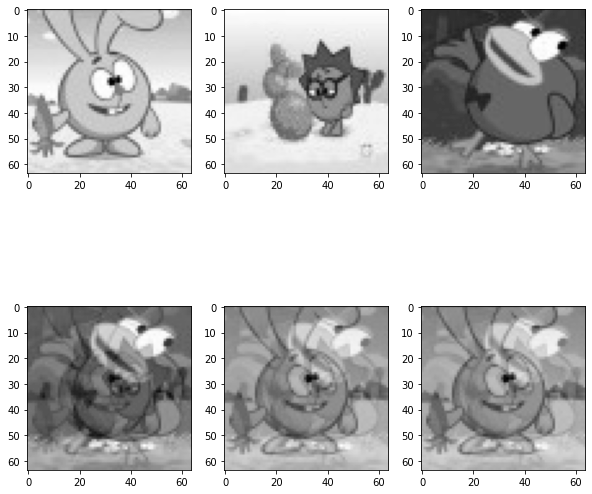

In [104]:
paths = ['smesh_img/krosh.jpg',
         'smesh_img/yuogic.jpg',
         'smesh_img/karich.jpg']

images, images_flatten = get_images(paths)

imgs_count = len(paths)

fig, ax = plt.subplots(2, imgs_count, figsize=(10, 10))

images_flatten = np.array(images_flatten)

rand_matrix = np.random.rand(imgs_count, imgs_count)
mixing = (rand_matrix / np.sum(rand_matrix, axis=1, keepdims=True))

mixed_images = mixing @ images_flatten

for idx, img in enumerate(images):
    ax[0][idx].imshow(img, cmap='gray')
    
for idx, img in enumerate(mixed_images):
    ax[1][idx].imshow(img.reshape(64, 64), cmap='gray')
    
plt.show()

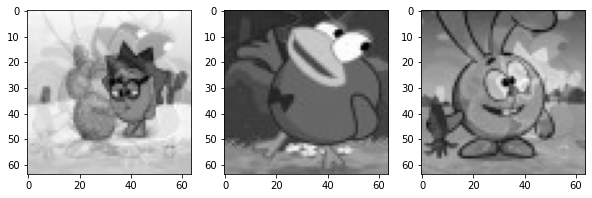

In [94]:
fig, ax = plt.subplots(1, imgs_count, figsize=(10, 10))

restored = CAMNS(mixed_images.T, imgs_count)

for idx, img in enumerate(restored):
    ax[idx].imshow(img.reshape(64, 64), cmap='gray')
    
plt.show()

### Вывод

Можем видеть, что хоть добиться идельного разделения не получилось, на каждой картинке значительно более четко отображается свой персонаж. При этом Кар-Карыч восстановился наиболее хорошо, вероятно, из-за отличающейся более темной цветовой гаммы.